<a href="https://colab.research.google.com/github/Mike-Ziegler/MANE_4962_PROJECT_SPRING24/blob/main/CAE_LDA_MLP_EXTREES_RFBest_FF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using a CAE, Extracting deep_features, applying feed forward, evaluating with classifiers: LDA, MLP, and extra trees**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from keras.models import Model
from keras.layers import Input, Conv1D, Flatten, Dense, Reshape, Conv1DTranspose
from keras.optimizers import Adam
import os
import re
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Define the file names
file_names = [
    "CAE1_32_64_20_512_8_10_20.xlsx",
    "CAE2_32_64_20_512_8_100_256.xlsx",
]

def load_data(file_name):
    # Load data
    df = pd.read_excel(file_name, header=[0, 1])  # Load with multi-level header
    feature_names = df.columns.to_flat_index()  # Get multi-level index
    X = df.values[:, :-1]  # Features (remove the last column which is the class label)
    y = df.values[:, -1]   # Class labels (last column)
    return X, y, feature_names

def preprocess_data(X):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def extract_cae_hyperparameters(file_name):
    # Extract CAE hyperparameters from the file name
    pattern = r"(CAE\d)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)\.xlsx"
    match = re.match(pattern, file_name)

    if match:
        cae_type = match.group(1)
        s1 = int(match.group(2))
        s2 = int(match.group(3))
        s3 = int(match.group(4))
        s4 = int(match.group(5))
        s5 = int(match.group(6))
        s6 = int(match.group(7))
        s7 = int(match.group(8))

        return {
            "s1": s1,
            "s2": s2,
            "s3": s3,
            "s4": s4,
            "s5": s5,
            "s6": s6,
            "s7": s7
        }
    else:
        return None

def build_cae(input_shape, num_original_features, s1, s2, s3, s4, s5, s6, s7):
    # Build Convolutional Autoencoder (CAE) based on extracted hyperparameters
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv1D(s1, 3, activation='relu', padding='same')(inputs)
    x = Conv1D(s2, 3, activation='relu', padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(s5, activation='relu')(x)

    # Decoder
    x = Dense(s4, activation='relu')(encoded)
    x = Dense(num_original_features, activation='relu')(x)
    x = Reshape((num_original_features, 1))(x)
    x = Conv1DTranspose(s3, 3, activation='relu', padding='same')(x)
    x = Conv1DTranspose(s2, 3, activation='relu', padding='same')(x)
    decoded = Conv1DTranspose(1, 3, activation='linear', padding='same')(x)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

    encoder = Model(inputs, encoded)
    return autoencoder, encoder

def feature_extraction(X, encoder):
    # Extract deep features using CAE encoder
    deep_features = encoder.predict(X)
    return deep_features

def evaluate_classification(X, y, clf):
    # Evaluate classification performance
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=kf)
    return scores.mean()

def apply_ffs(X, y, clf):
    # Apply Forward Feature Selection
    sfs = SFS(clf,
              k_features='best',
              forward=True,
              floating=False,
              verbose=0,
              scoring='accuracy',
              cv=3) #lower cv for testing
    sfs.fit(X, y)
    return sfs.k_feature_names_, sfs.k_score_

for file_name in file_names:
    print("Processing file:", file_name)

    # Load data
    X, y, feature_names = load_data(file_name)

    # Shuffle and Split for preprocessing and CAE training
    X_preprocess, X_cae_train, y_preprocess, y_cae_train = train_test_split(X, y, test_size=0.4, random_state=42)

    # Preprocess data using the scaled data from the preprocessing part
    X_scaled = preprocess_data(X_preprocess)



    # Extract CAE hyperparameters
    cae_hyperparameters = extract_cae_hyperparameters(file_name)
    # print("Extracted CAE Hyperparameters:")
    # print(cae_hyperparameters)

    # Build and train CAE
    input_shape = (X_scaled.shape[1], 1)
    num_original_features = X_scaled.shape[1]
    cae, encoder = build_cae(input_shape, num_original_features, **cae_hyperparameters)
    cae.fit(X_cae_train, X_cae_train, epochs=20, batch_size=32, verbose=0) #lower epochs for testing

    # Extract deep features
    deep_features = feature_extraction(X_scaled, encoder)

    # Trim deep features to match the number of original features
    deep_features = deep_features[:, :num_original_features]

    # Combine Standard and Deep Features
    X_combined = np.hstack((X_scaled, deep_features))

    # Ensure X_combined and y have the same number of samples
    if X_combined.shape[0] != y.shape[0]:
        # If not, trim y to match the number of samples in X_combined
        y = y[:X_combined.shape[0]]

    # Initialize and evaluate classifiers
    classifiers = [
        LDA(solver='lsqr'),
        MLPClassifier(hidden_layer_sizes=(10, 5)), #tune this and maybe adjust cv= in apply_ffs
        ExtraTreesClassifier(n_estimators=100) #Reduce n_estimators
    ]

    for clf in classifiers:
        try:
            print("Classifier:", clf.__class__.__name__)

            # Evaluate classification performance
            accuracy = evaluate_classification(X_combined, y, clf)
            print("Accuracy:", accuracy)

            # Apply Forward Feature Selection
            selected_features, feature_score = apply_ffs(X_combined, y, clf)
            print("Selected Features:", selected_features)
            print("Feature Score:", feature_score)
        except Exception as e:
            print("Error processing classifier", clf.__class__.__name__)
            print(e)

    print("-" * 80)


Processing file: CAE1_32_64_20_512_8_10_20.xlsx
419/419 [==============================] - 1s 2ms/step
Classifier: LinearDiscriminantAnalysis
Accuracy: 0.9176435200788585
Selected Features: ('0',)
Feature Score: 0.9176435497918899
Classifier: MLPClassifier
Accuracy: 0.9171955081162618
Selected Features: ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '27')
Feature Score: 0.9177182212375291
Classifier: ExtraTreesClassifier
Accuracy: 0.9175688653569474
Selected Features: ('8',)
Feature Score: 0.9176435497918899
--------------------------------------------------------------------------------
Processing file: CAE2_32_64_20_512_8_100_256.xlsx
419/419 [==============================] - 1s 2ms/step
Classifier: LinearDiscriminantAnalysis
Accuracy: 0.9176435200788585
Selected Features: ('0',)
Feature Score: 0.9176435497918899
Classifier: MLPClassifier
Accuracy: 0.9171207418861774
Selected Features: ('0', '1', '2', '3', '4', '18')
Feature Score: 0.9177182212375291
Classifier: ExtraTrees

**Visualizing the data for this method using a confusion matrix revealed the data being used was only one class. This model is only 92% accurate when looking at one classifier.**

**Shuffling the data and checking the confusion matrix to make sure the data contains both classes.**

Processing file: CAE1_32_64_20_512_8_10_20.xlsx
419/419 [==============================] - 1s 2ms/step
Classifier: LinearDiscriminantAnalysis
Accuracy: 0.5499904242356324
Selected Features: ('4', '5', '8', '9', '17', '20', '21', '22', '23', '24')
Feature Score: 0.5527514546298637


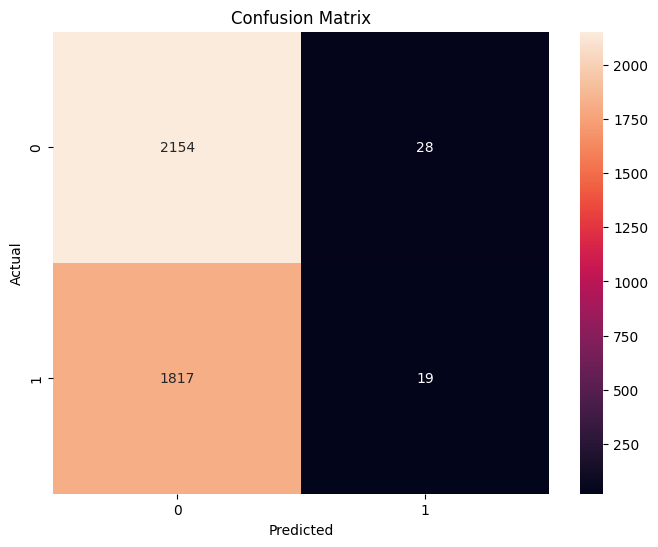

Classifier: MLPClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy: 0.5480496523593318


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from keras.models import Model
from keras.layers import Input, Conv1D, Flatten, Dense, Reshape, Conv1DTranspose
from keras.optimizers import Adam
import os
import re
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
# Suppress ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Define the file names
file_names = [
    "CAE1_32_64_20_512_8_10_20.xlsx",
    "CAE2_32_64_20_512_8_100_256.xlsx",
]

def load_data(file_name):
    # Load data
    df = pd.read_excel(file_name, header=[0, 1])  # Load with multi-level header
    feature_names = df.columns.to_flat_index()  # Get multi-level index
    X = df.values[:, :-1]  # Features (remove the last column which is the class label)
    y = df.values[:, -1]   # Class labels (last column)
    return X, y, feature_names

def preprocess_data(X):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def extract_cae_hyperparameters(file_name):
    # Extract CAE hyperparameters from the file name
    pattern = r"(CAE\d)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)\.xlsx"
    match = re.match(pattern, file_name)

    if match:
        cae_type = match.group(1)
        s1 = int(match.group(2))
        s2 = int(match.group(3))
        s3 = int(match.group(4))
        s4 = int(match.group(5))
        s5 = int(match.group(6))
        s6 = int(match.group(7))
        s7 = int(match.group(8))

        return {
            "s1": s1,
            "s2": s2,
            "s3": s3,
            "s4": s4,
            "s5": s5,
            "s6": s6,
            "s7": s7
        }
    else:
        return None

def build_cae(input_shape, num_original_features, s1, s2, s3, s4, s5, s6, s7):
    # Build Convolutional Autoencoder (CAE) based on extracted hyperparameters
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv1D(s1, 3, activation='relu', padding='same')(inputs)
    x = Conv1D(s2, 3, activation='relu', padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(s5, activation='relu')(x)

    # Decoder
    x = Dense(s4, activation='relu')(encoded)
    x = Dense(num_original_features, activation='relu')(x)
    x = Reshape((num_original_features, 1))(x)
    x = Conv1DTranspose(s3, 3, activation='relu', padding='same')(x)
    x = Conv1DTranspose(s2, 3, activation='relu', padding='same')(x)
    decoded = Conv1DTranspose(1, 3, activation='linear', padding='same')(x)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

    encoder = Model(inputs, encoded)
    return autoencoder, encoder

def feature_extraction(X, encoder):
    # Extract deep features using CAE encoder
    deep_features = encoder.predict(X)
    return deep_features

def evaluate_classification(X, y, clf):
    # Evaluate classification performance
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=kf)
    return scores.mean()

def apply_ffs(X, y, clf):
    # Apply Forward Feature Selection
    sfs = SFS(clf,
              k_features='best',
              forward=True,
              floating=False,
              verbose=0,
              scoring='accuracy',
              cv=3) #lower cv for testing
    sfs.fit(X, y)
    return sfs.k_feature_names_, sfs.k_score_

for file_name in file_names:
    print("Processing file:", file_name)

    # Load data
    X, y, feature_names = load_data(file_name)

    # Shuffle and Split for preprocessing and CAE training
    X, y = shuffle(X, y, random_state=42)  # Shuffle the data
    X_preprocess, X_cae_train, y_preprocess, y_cae_train = train_test_split(X, y, test_size=0.4, random_state=42)

    # Preprocess data using the scaled data from the preprocessing part
    X_scaled = preprocess_data(X_preprocess)

    # Extract CAE hyperparameters
    cae_hyperparameters = extract_cae_hyperparameters(file_name)

    # Build and train CAE
    input_shape = (X_scaled.shape[1], 1)
    num_original_features = X_scaled.shape[1]
    cae, encoder = build_cae(input_shape, num_original_features, **cae_hyperparameters)
    cae.fit(X_cae_train, X_cae_train, epochs=50, batch_size=64, verbose=0) #lower epochs for testing

    # Extract deep features
    deep_features = feature_extraction(X_scaled, encoder)

    # Trim deep features to match the number of original features
    deep_features = deep_features[:, :num_original_features]

    # Combine Standard and Deep Features
    X_combined = np.hstack((X_scaled, deep_features))

    # Ensure X_combined and y have the same number of samples
    if X_combined.shape[0] != y.shape[0]:
        # If not, trim y to match the number of samples in X_combined
        y = y[:X_combined.shape[0]]

    # Initialize and evaluate classifiers
    classifiers = [
        LDA(solver='lsqr', tol=1e-2),
        MLPClassifier(hidden_layer_sizes=(5,2),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam'), #tune this and maybe adjust cv= in apply_ffs
        ExtraTreesClassifier(n_estimators=500, max_features=10,min_samples_leaf=100, random_state=42)
    ]

    for clf in classifiers:
        try:
            print("Classifier:", clf.__class__.__name__)

            # Evaluate classification performance
            accuracy = evaluate_classification(X_combined, y, clf)
            print("Accuracy:", accuracy)

            # Apply Forward Feature Selection
            selected_features, feature_score = apply_ffs(X_combined, y, clf)
            print("Selected Features:", selected_features)
            print("Feature Score:", feature_score)

            # Plot Confusion Matrix
            X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='g')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            # plt.figure()
            # confusion_matrix(cm, labels=["biocomposite", "fiber epoxy composite"], title=clf.__class__.__name__)
            # plt.show()

        except Exception as e:
            print("Error processing classifier", clf.__class__.__name__)
            print(e)

    print("-" * 80)


**Best Results**

Processing file: CAE1_32_64_20_512_8_10_20.xlsx

Classifier: LinearDiscriminantAnalysis

Accuracy: 0.5499904242356324

Selected Features: ('4', '5', '8', '9', '17', '20', '21', '22', '23', '24')

Feature Score: 0.5527514546298637

**Shuffling the data lowered the accuracy from 92% to 53%. This highlights the importance of visualizing the data before drawing conclusions on accuracy. Manually tuning classifier hyperparameters.**

**Removing the CAE because the data set already has deep features extracted from a CAE. Training the classifiers on the scaled data, evaluating the classifier performance and plotting the confusion matrix. A feed forward feature selection for each classifier is used.**

Processing file: CAE1_32_64_20_512_8_10_20.xlsx
Classifier: LinearDiscriminantAnalysis
Accuracy: 0.7437658653128266
Selected Features: ('1', '2', '3', '4', '5', '6', '8', '9', '11', '12', '13', '15', '16', '17', '18', '19', '20')
Feature Score: 0.7542553078551567


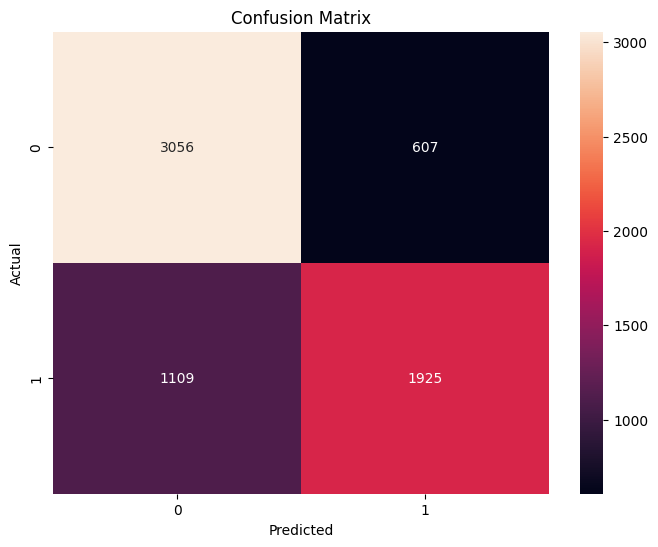

Classifier: MLPClassifier
Accuracy: 0.8243989846199791
Selected Features: ('0', '1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20')
Feature Score: 0.8244593355644948


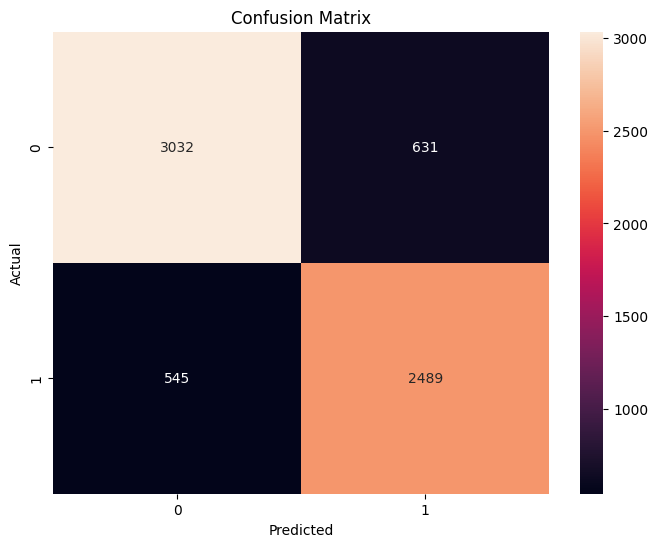

Classifier: ExtraTreesClassifier
Accuracy: 0.7661639540092579
Selected Features: ('0', '1', '2', '3', '8', '9', '13', '15', '18', '19')
Feature Score: 0.7691666649464568


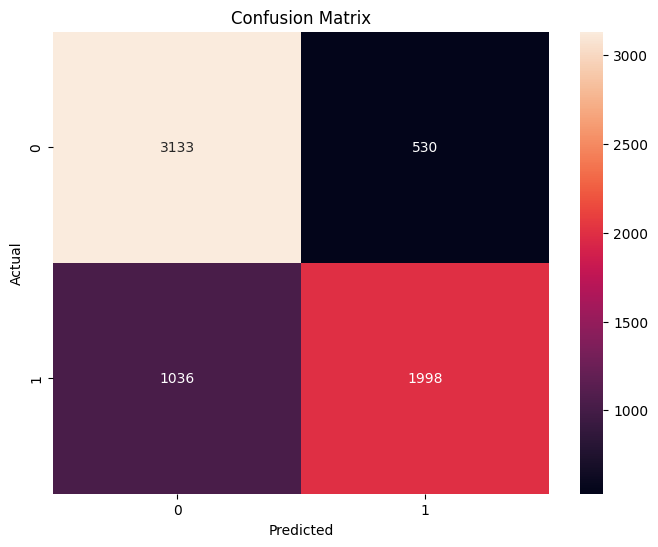

--------------------------------------------------------------------------------
Processing file: CAE2_32_64_20_512_8_100_256.xlsx
Classifier: LinearDiscriminantAnalysis
Accuracy: 0.7483948036434225
Selected Features: ('1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '13', '14', '15', '17', '18', '19', '20')
Feature Score: 0.7596313201864078


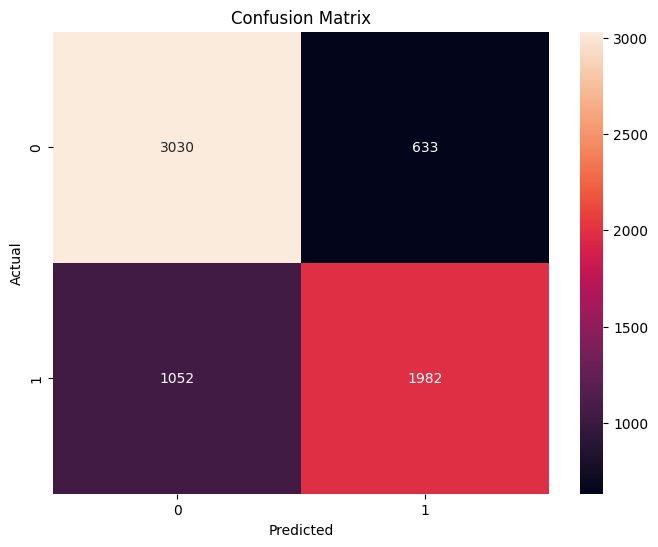

Classifier: MLPClassifier
Accuracy: 0.8336568612811707
Selected Features: ('0', '2', '5', '6', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20')
Feature Score: 0.8295148113514589


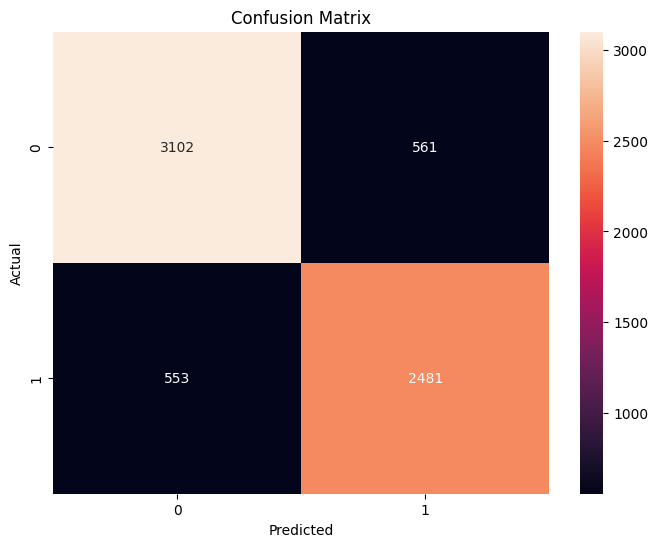

Classifier: ExtraTreesClassifier
Accuracy: 0.7676571599223533
Selected Features: ('0', '1', '2', '3', '4', '5', '8', '10', '14', '15', '18')
Feature Score: 0.771726755073661


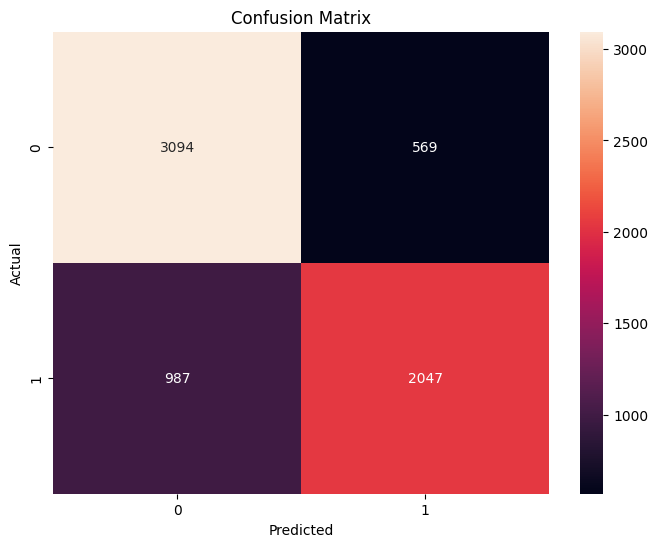

--------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.utils import shuffle
# Define the file names
# Define the file names
file_names = [
    "CAE1_32_64_20_512_8_10_20.xlsx",
    "CAE2_32_64_20_512_8_100_256.xlsx",
]

def load_data(file_name):
    # Load data
    df = pd.read_excel(file_name, header=[0, 1])  # Load with multi-level header
    feature_names = df.columns.to_flat_index()  # Get multi-level index
    X = df.values[:, :-1]  # Features (remove the last column which is the class label)
    y = df.values[:, -1]   # Class labels (last column)
    return X, y, feature_names

def preprocess_data(X):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def evaluate_classification(X, y, clf):
    # Evaluate classification performance
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=kf)
    return scores.mean()

def apply_ffs(X, y, clf):
    # Apply Forward Feature Selection
    sfs = SFS(clf,
              k_features='best',
              forward=True,
              floating=False,
              verbose=0,
              scoring='accuracy',
              cv=3) #lower cv for testing
    sfs.fit(X, y)
    return sfs.k_feature_names_, sfs.k_score_

for file_name in file_names:
    print("Processing file:", file_name)

    # Load data
    X, y, feature_names = load_data(file_name)

    # Shuffle and Split for preprocessing and CAE training
    X, y = shuffle(X, y, random_state=42)  # Shuffle the data

    # Preprocess data using the scaled data from the preprocessing part
    X_scaled = preprocess_data(X)

    # Split the preprocessed data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Initialize classifiers
    lda = LDA(solver='lsqr', tol=1e-3)
    mlp = MLPClassifier(hidden_layer_sizes=(20, 10, 5, 2), max_iter=500, activation='relu', solver='adam', alpha=0.001)
    etc = ExtraTreesClassifier(n_estimators=500, max_features=10, min_samples_leaf=100, random_state=42)

    classifiers = [lda, mlp, etc]

    # Train classifiers
    for clf in classifiers:
        try:
            print("Classifier:", clf.__class__.__name__)

            # Train each classifier on the preprocessed training data
            clf.fit(X_train, y_train)

            # Evaluate classification performance
            accuracy = clf.score(X_test, y_test)
            print("Accuracy:", accuracy)

            # Apply Forward Feature Selection
            selected_features, feature_score = apply_ffs(X_train, y_train, clf)
            print("Selected Features:", selected_features)
            print("Feature Score:", feature_score)

            # Plot Confusion Matrix
            y_pred = clf.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='g')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()

        except Exception as e:
            print("Error processing classifier", clf.__class__.__name__)
            print(e)

    print("-" * 80)

**MLP Classifier is the most accurate for both data sets at 82-83%. This is similar to using Tensor Flow NN.**

**Best Results**

Classifier: MLPClassifier

Accuracy: 0.8336568612811707

Selected Features: ('0', '2', '5', '6', '10', '11', '12', '13', '14', '15',
'16', '17', '18', '19', '20')

Feature Score: 0.8295148113514589

Processing file: CAE1_32_64_20_512_8_10_20.xlsx
Classifier: GaussianNB
Accuracy: 0.6322233836045991
Selected Features: ('6', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20')
Feature Score: 0.6859077552666193


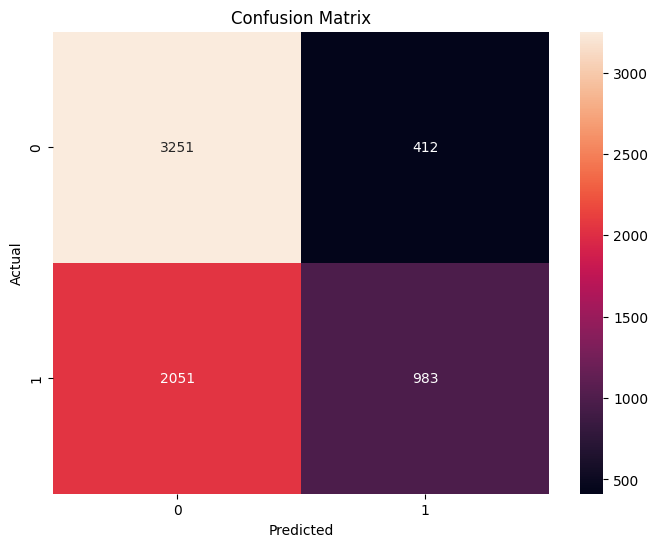

--------------------------------------------------------------------------------
Processing file: CAE2_32_64_20_512_8_100_256.xlsx
Classifier: GaussianNB
Accuracy: 0.6455129162311483
Selected Features: ('6', '10', '11', '12', '15', '18')
Feature Score: 0.7036348871154017


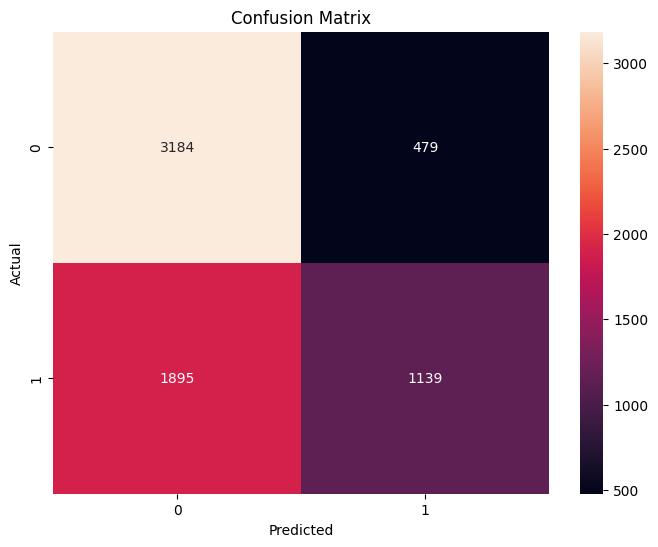

--------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# Define the file names
file_names = [
    "CAE1_32_64_20_512_8_10_20.xlsx",
    "CAE2_32_64_20_512_8_100_256.xlsx",
]

def load_data(file_name):
    # Load data
    df = pd.read_excel(file_name, header=[0, 1])  # Load with multi-level header
    feature_names = df.columns.to_flat_index()  # Get multi-level index
    X = df.values[:, :-1]  # Features (remove the last column which is the class label)
    y = df.values[:, -1]   # Class labels (last column)
    return X, y, feature_names

def preprocess_data(X):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def apply_ffs(X, y, clf):
    # Apply Forward Feature Selection
    sfs = SFS(clf,
              k_features='best',
              forward=True,
              floating=False,
              verbose=0,
              scoring='accuracy',
              cv=3)
    sfs.fit(X, y)
    return sfs.k_feature_names_, sfs.k_score_

for file_name in file_names:
    print("Processing file:", file_name)

    # Load data
    X, y, feature_names = load_data(file_name)

    # Shuffle and Split for preprocessing and CAE training
    X, y = shuffle(X, y, random_state=42)  # Shuffle the data

    # Preprocess data using the scaled data from the preprocessing part
    X_scaled = preprocess_data(X)

    # Split the preprocessed data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Initialize Gaussian Naive Bayes classifier
    nb = GaussianNB()

    try:
        print("Classifier:", nb.__class__.__name__)

        # Train Gaussian Naive Bayes on the preprocessed training data
        nb.fit(X_train, y_train)

        # Evaluate classification performance
        accuracy = nb.score(X_test, y_test)
        print("Accuracy:", accuracy)

        # Apply Forward Feature Selection
        selected_features, feature_score = apply_ffs(X_train, y_train, nb)
        print("Selected Features:", selected_features)
        print("Feature Score:", feature_score)

        # Plot Confusion Matrix
        y_pred = nb.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    except Exception as e:
        print("Error processing classifier", nb.__class__.__name__)
        print(e)

    print("-" * 80)


**Gausian did well, but not great. Tuning the model with gridsearchCV.**

**Best Results**

Processing file: CAE2_32_64_20_512_8_100_256.xlsx

Classifier: GaussianNB

Accuracy: 0.6455129162311483

Selected Features: ('6', '10', '11', '12', '15', '18')

Feature Score: 0.7036348871154017

Processing file: CAE1_32_64_20_512_8_10_20.xlsx
Classifier: GaussianNB
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'var_smoothing': 0.0003511191734215131}
Accuracy: 0.6322233836045991
Selected Features: ('6', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20')
Feature Score: 0.6859077552666193


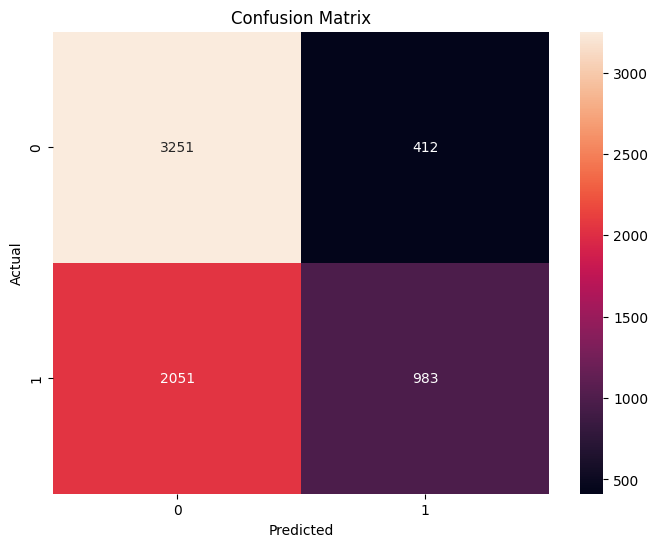

--------------------------------------------------------------------------------
Processing file: CAE2_32_64_20_512_8_100_256.xlsx
Classifier: GaussianNB
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'var_smoothing': 0.001}
Accuracy: 0.6453635956398387
Selected Features: ('6', '10', '11', '12', '15', '18')
Feature Score: 0.7035069034973048


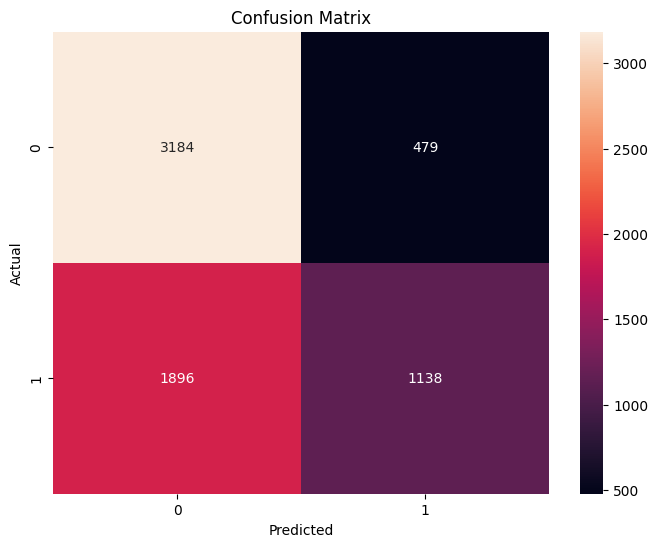

--------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# Define the file names
file_names = [
    "CAE1_32_64_20_512_8_10_20.xlsx",
    "CAE2_32_64_20_512_8_100_256.xlsx",
]

def load_data(file_name):
    # Load data
    df = pd.read_excel(file_name, header=[0, 1])  # Load with multi-level header
    feature_names = df.columns.to_flat_index()  # Get multi-level index
    X = df.values[:, :-1]  # Features (remove the last column which is the class label)
    y = df.values[:, -1]   # Class labels (last column)
    return X, y, feature_names

def preprocess_data(X):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def apply_ffs(X, y, clf):
    # Apply Forward Feature Selection
    sfs = SFS(clf,
              k_features='best',
              forward=True,
              floating=False,
              verbose=0,
              scoring='accuracy',
              cv=3)
    sfs.fit(X, y)
    return sfs.k_feature_names_, sfs.k_score_

for file_name in file_names:
    print("Processing file:", file_name)

    # Load data
    X, y, feature_names = load_data(file_name)

    # Shuffle and Split for preprocessing and CAE training
    X, y = shuffle(X, y, random_state=42)  # Shuffle the data

    # Preprocess data using the scaled data from the preprocessing part
    X_scaled = preprocess_data(X)

    # Split the preprocessed data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Initialize Gaussian Naive Bayes classifier
    nb = GaussianNB()

    try:
        print("Classifier:", nb.__class__.__name__)

        # Grid Search for hyperparameter tuning
        param_grid = {
            'var_smoothing': np.logspace(0,-9, num=100)
        }
        grid_search = GridSearchCV(nb, param_grid, cv=3, verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        nb_best = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)

        # Train Gaussian Naive Bayes on the preprocessed training data
        nb_best.fit(X_train, y_train)

        # Evaluate classification performance
        accuracy = nb_best.score(X_test, y_test)
        print("Accuracy:", accuracy)

        # Apply Forward Feature Selection
        selected_features, feature_score = apply_ffs(X_train, y_train, nb_best)
        print("Selected Features:", selected_features)
        print("Feature Score:", feature_score)

        # Plot Confusion Matrix
        y_pred = nb_best.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    except Exception as e:
        print("Error processing classifier", nb.__class__.__name__)
        print(e)

    print("-" * 80)


**Tunning didn't help.**

**Best Results**

Processing file: CAE2_32_64_20_512_8_100_256.xlsx

Classifier: GaussianNB

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best Parameters: {'var_smoothing': 0.001}

Accuracy: 0.6453635956398387

Selected Features: ('6', '10', '11', '12', '15', '18')

Feature Score: 0.7035069034973048

**Trying feed forward selection with random forest and Gaussian**

Processing file: CAE1_32_64_20_512_8_10_20.xlsx
Classifier: Gaussian Naive Bayes
Accuracy: 0.6349111542481708
Selected Features: ('6', '8', '10', '12', '13', '15', '16', '17', '19')
Feature Score: 0.6890577454550848


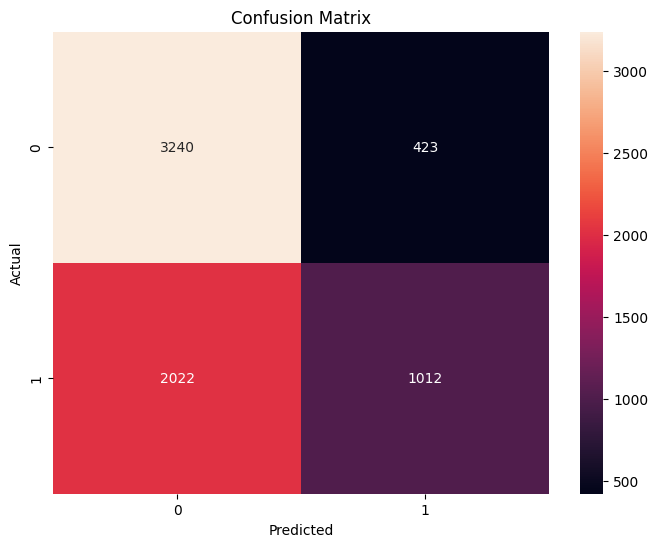

Classifier: Random Forest
Accuracy: 0.8469463939077199
Selected Features: ('0', '1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20')
Feature Score: 0.851977205471996


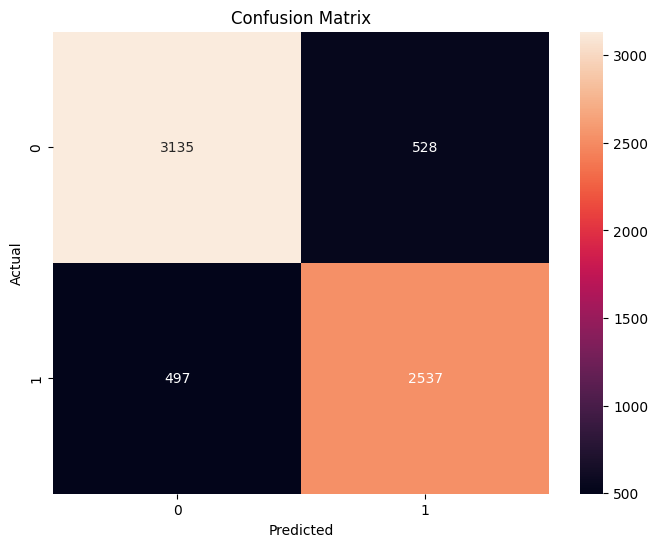

--------------------------------------------------------------------------------
Processing file: CAE2_32_64_20_512_8_100_256.xlsx
Classifier: Gaussian Naive Bayes
Accuracy: 0.6487979692399581
Selected Features: ('6', '8', '10', '12', '15', '18')
Feature Score: 0.6997797927868383


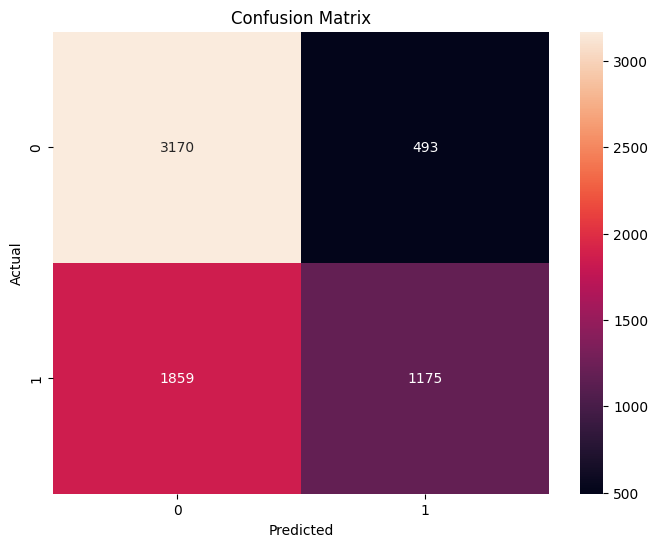

Classifier: Random Forest
Accuracy: 0.847245035090339
Selected Features: ('0', '1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19', '20')
Feature Score: 0.858062458670589


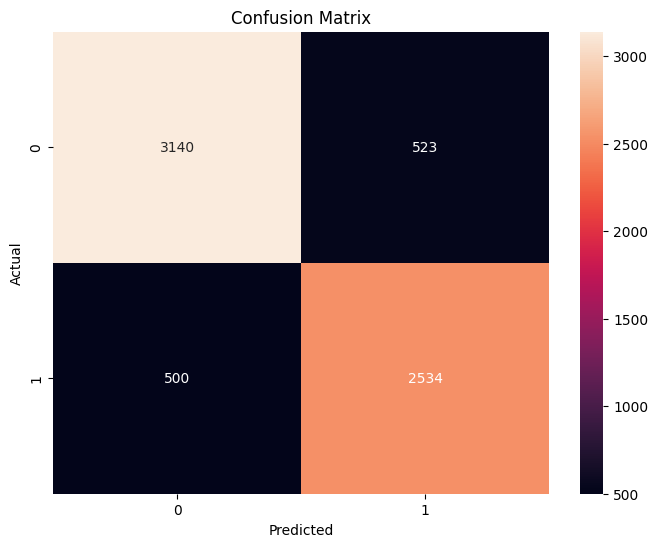

--------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# Define the file names
file_names = [
    "CAE1_32_64_20_512_8_10_20.xlsx",
    "CAE2_32_64_20_512_8_100_256.xlsx",
]

def load_data(file_name):
    # Load data
    df = pd.read_excel(file_name, header=[0, 1])  # Load with multi-level header
    feature_names = df.columns.to_flat_index()  # Get multi-level index
    X = df.values[:, :-1]  # Features (remove the last column which is the class label)
    y = df.values[:, -1]   # Class labels (last column)
    return X, y, feature_names

def preprocess_data(X):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def apply_ffs(X, y, clf):
    # Apply Forward Feature Selection
    sfs = SFS(clf,
              k_features='best',
              forward=True,
              floating=False,
              verbose=0,
              scoring='accuracy',
              cv=3)
    sfs.fit(X, y)
    return sfs.k_feature_names_, sfs.k_score_

for file_name in file_names:
    print("Processing file:", file_name)

    # Load data
    X, y, feature_names = load_data(file_name)

    # Shuffle and Split for preprocessing and CAE training
    X, y = shuffle(X, y, random_state=42)  # Shuffle the data

    # Preprocess data using the scaled data from the preprocessing part
    X_scaled = preprocess_data(X)

    # Split the preprocessed data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Apply SMOTE to handle imbalanced data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Initialize models
    nb = GaussianNB()
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train and evaluate models
    models = [("Gaussian Naive Bayes", nb), ("Random Forest", rf)]
    for name, clf in models:
        try:
            print("Classifier:", name)

            # Train the classifier
            clf.fit(X_resampled, y_resampled)

            # Evaluate classification performance
            accuracy = clf.score(X_test, y_test)
            print("Accuracy:", accuracy)

            # Apply Forward Feature Selection
            selected_features, feature_score = apply_ffs(X_resampled, y_resampled, clf)
            print("Selected Features:", selected_features)
            print("Feature Score:", feature_score)

            # Plot Confusion Matrix
            y_pred = clf.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='g')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()

        except Exception as e:
            print("Error processing classifier", name)
            print(e)

    print("-" * 80)


**Random Forest with Feedforward selection did the best overall**

**Random Forest Results**

Classifier: Random Forest

Accuracy: 0.8469463939077199

Selected Features: ('0', '1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20')

Feature Score: 0.851977205471996

Classifier: Random Forest

Accuracy: 0.847245035090339

Selected Features: ('0', '1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19', '20')

Feature Score: 0.858062458670589